# 요약

#### train(logerror(종속변수), id,날짜) -> logerror에 대한 scatter확인 -> 이상치를 x로 통일 -> 월별 거래건수(날짜)/중복id건수(id) 
#### properties_2016(독립변수) ->missingno(barh), 결측치(평균)
#### train + properties_2016 ->  -> float64로 상관계수(barh/히트맵) -> 중요독립변수/error로 count/box/joint/violin/ggplot -> xgb 변수중요도



이 노트북에서 Zillow 경품 대회에 제공된 데이터를 탐색하고 탐색해 보겠습니다. 데이터에 대해 자세히 알아보기 전에 경쟁에 대해 조금 더 자세히 알아보겠습니다.

**질로:**

Zillow는 2006년에 설립된 온라인 부동산 데이터베이스 회사입니다. - Wikipedia

**제스티메이트:**

"Zestimates"는 각 부동산에 대한 수백 개의 데이터 포인트를 분석하는 750만 개의 통계 및 기계 학습 모델을 기반으로 추정되는 주택 가치입니다. 그리고 중앙값 오차 범위를 지속적으로 개선함으로써(초기 14%에서 현재 5%로),

**Objective:**

Zestimate 잔차 오차를 개선하기 위한 모델 구축.

경쟁은 2단계로 진행됩니다. 이 공개 경쟁은 2018년 1월까지 계속되며 상금은 $50,000입니다. [상세내용][1]과 [대회개요][2]는 내용이 많이 다르기 때문에 반드시 읽어주시기 바랍니다.

먼저 필요한 모듈을 가져오도록 합시다.


  [1]: https://www.kaggle.com/c/zillow-prize-1#prizes
  [2]: https://www.kaggle.com/c/zillow-prize-1#Competition%20Overview

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()

%matplotlib inline

pd.options.mode.chained_assignment = None # error, warning 무시 --> 경고 끔
pd.options.display.max_columns = 999 # 표를 출력할 때 최대 칼럼 수

Let us list the files present in the input folder.

First let us start with the train file exploration.

In [2]:
train_df = pd.read_csv("./input/train_2016_v2.csv", parse_dates=["transactiondate"])
train_df.shape

(90275, 3)

In [3]:
train_df.head()

,parcelid,logerror,transactiondate
0,11016594,0.0276,2016-01-01
1,14366692,-0.1684,2016-01-01
2,12098116,-0.0040,2016-01-01
3,12643413,0.0218,2016-01-02
4,14432541,-0.0050,2016-01-02


**Logerror:**

이 대회의 대상 변수는 "logerror" 필드입니다. 그럼 먼저 이 분야에 대한 분석을 해보자.


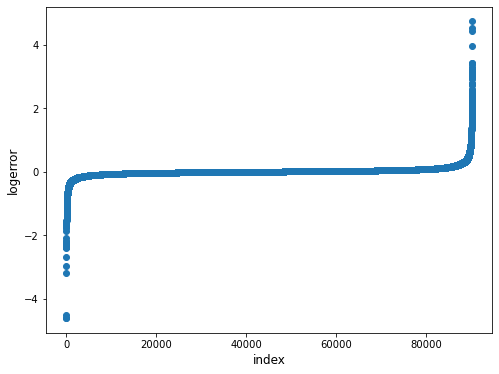

In [4]:
plt.figure(figsize=(8,6))
plt.scatter(range(train_df.shape[0]), np.sort(train_df['logerror'].values)) # x=0~90275, y=logerror 낮은순부터
plt.xlabel('index', fontsize=12)
plt.ylabel('logerror', fontsize=12)
plt.show()

이것은 양쪽 끝에 약간의 이상값이 있는 것처럼 보입니다.!

이상치를 제거한 다음 히스토그램 플롯을 작성해 보겠습니다.


C:\Users\HOME\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


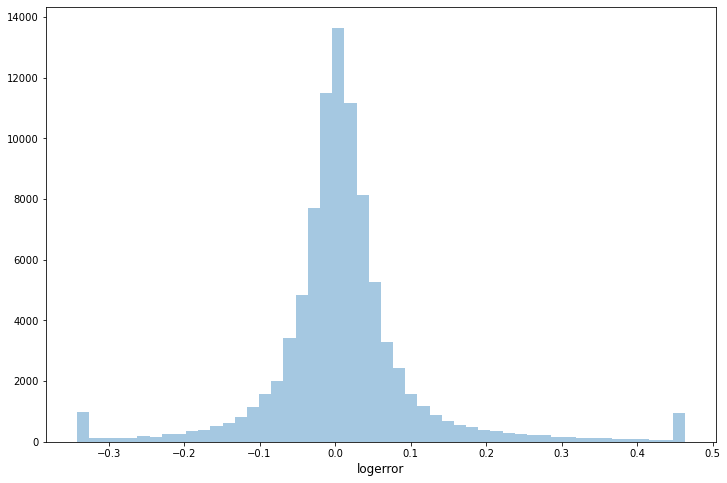

In [5]:
ulimit = np.percentile(train_df.logerror.values, 99) # 0.46388199999999635
llimit = np.percentile(train_df.logerror.values, 1) # -0.3425
train_df['logerror'].iloc[train_df['logerror']>ulimit] = ulimit
train_df['logerror'].iloc[train_df['logerror']<llimit] = llimit

plt.figure(figsize=(12,8))
sns.distplot(train_df.logerror.values, bins=50, kde=False)
plt.xlabel('logerror', fontsize=12)
plt.show()

우와. 로그 오류에 대한 좋은 정규 분포.

**Transaction Date:**

이제 날짜 필드를 탐색해 보겠습니다. 먼저 월별 거래 건수를 확인해보자.


C:\Users\HOME\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


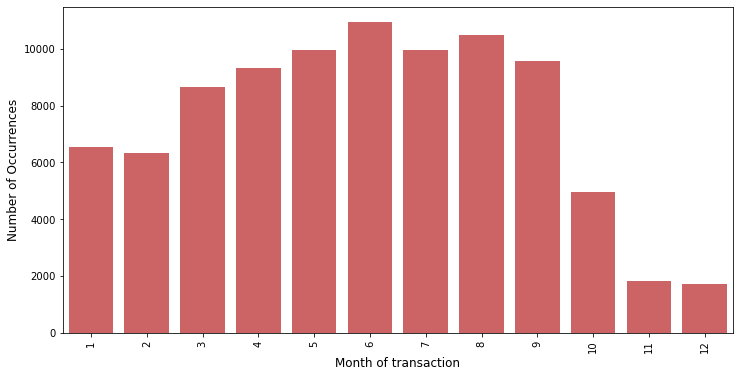

In [6]:
train_df['transaction_month'] = train_df['transactiondate'].dt.month

cnt_srs = train_df['transaction_month'].value_counts()
plt.figure(figsize=(12,6))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8, color=color[3])
plt.xticks(rotation='vertical')
plt.xlabel('Month of transaction', fontsize=12)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.show()

데이터 페이지에서도 볼 수 있듯이
* 훈련 데이터에는 2016년 10월 15일 이전의 모든 거래와 2016년 10월 15일 이후의 일부 거래가 있습니다.*

그래서 우리는 지난 3개월 동안 더 짧은 막대를 가지고 있습니다.


**Parcel Id:**

In [7]:
(train_df['parcelid'].value_counts().reset_index())['parcelid'].value_counts()

1    90026
2      123
3        1
Name: parcelid, dtype: int64

따라서 대부분의 구획 ID는 데이터 세트에서 한 번만 나타납니다.

**Properties 2016:**

Now let us explore the properties_2016 file. 

In [8]:
prop_df = pd.read_csv("./input/properties_2016.csv")
prop_df.shape

C:\Users\HOME\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (22,32,34,49,55) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


(2985217, 58)

In [9]:
prop_df.head()

,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,finishedfloor1squarefeet,calculatedfinishedsquarefeet,finishedsquarefeet12,finishedsquarefeet13,finishedsquarefeet15,finishedsquarefeet50,finishedsquarefeet6,fips,fireplacecnt,fullbathcnt,garagecarcnt,garagetotalsqft,hashottuborspa,heatingorsystemtypeid,latitude,longitude,lotsizesquarefeet,poolcnt,poolsizesum,pooltypeid10,pooltypeid2,pooltypeid7,propertycountylandusecode,propertylandusetypeid,propertyzoningdesc,rawcensustractandblock,regionidcity,regionidcounty,regionidneighborhood,regionidzip,roomcnt,storytypeid,threequarterbathnbr,typeconstructiontypeid,unitcnt,yardbuildingsqft17,yardbuildingsqft26,yearbuilt,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock
0,10754147,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6037.0,NaN,NaN,NaN,NaN,NaN,NaN,34144442.0,-118654084.0,85768.0,NaN,NaN,NaN,NaN,NaN,010D,269.0,NaN,6.037800e+07,37688.0,3101.0,NaN,96337.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.0,2015.0,9.0,NaN,NaN,NaN,NaN
1,10759547,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6037.0,NaN,NaN,NaN,NaN,NaN,NaN,34140430.0,-118625364.0,4083.0,NaN,NaN,NaN,NaN,NaN,0109,261.0,LCA11*,6.037800e+07,37688.0,3101.0,NaN,96337.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27516.0,2015.0,27516.0,NaN,NaN,NaN,NaN
2,10843547,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,73026.0,NaN,NaN,73026.0,NaN,NaN,6037.0,NaN,NaN,NaN,NaN,NaN,NaN,33989359.0,-118394633.0,63085.0,NaN,NaN,NaN,NaN,NaN,1200,47.0,LAC2,6.037703e+07,51617.0,3101.0,NaN,96095.0,0.0,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,650756.0,1413387.0,2015.0,762631.0,20800.37,NaN,NaN,NaN
3,10859147,NaN,NaN,NaN,0.0,0.0,3.0,7.0,NaN,NaN,NaN,5068.0,NaN,NaN,5068.0,NaN,NaN,6037.0,NaN,NaN,NaN,NaN,NaN,NaN,34148863.0,-118437206.0,7521.0,NaN,NaN,NaN,NaN,NaN,1200,47.0,LAC2,6.037141e+07,12447.0,3101.0,27080.0,96424.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,1948.0,1.0,NaN,571346.0,1156834.0,2015.0,585488.0,14557.57,NaN,NaN,NaN
4,10879947,NaN,NaN,NaN,0.0,0.0,4.0,NaN,NaN,NaN,NaN,1776.0,NaN,NaN,1776.0,NaN,NaN,6037.0,NaN,NaN,NaN,NaN,NaN,NaN,34194168.0,-118385816.0,8512.0,NaN,NaN,NaN,NaN,NaN,1210,31.0,LAM1,6.037123e+07,12447.0,3101.0,46795.0,96450.0,0.0,NaN,NaN,NaN,1.0,NaN,NaN,1947.0,NaN,NaN,193796.0,433491.0,2015.0,239695.0,5725.17,NaN,NaN,NaN


데이터 세트에는 NaN 값이 너무 많습니다. 그래서 먼저 그것에 대한 탐색을 해보자.


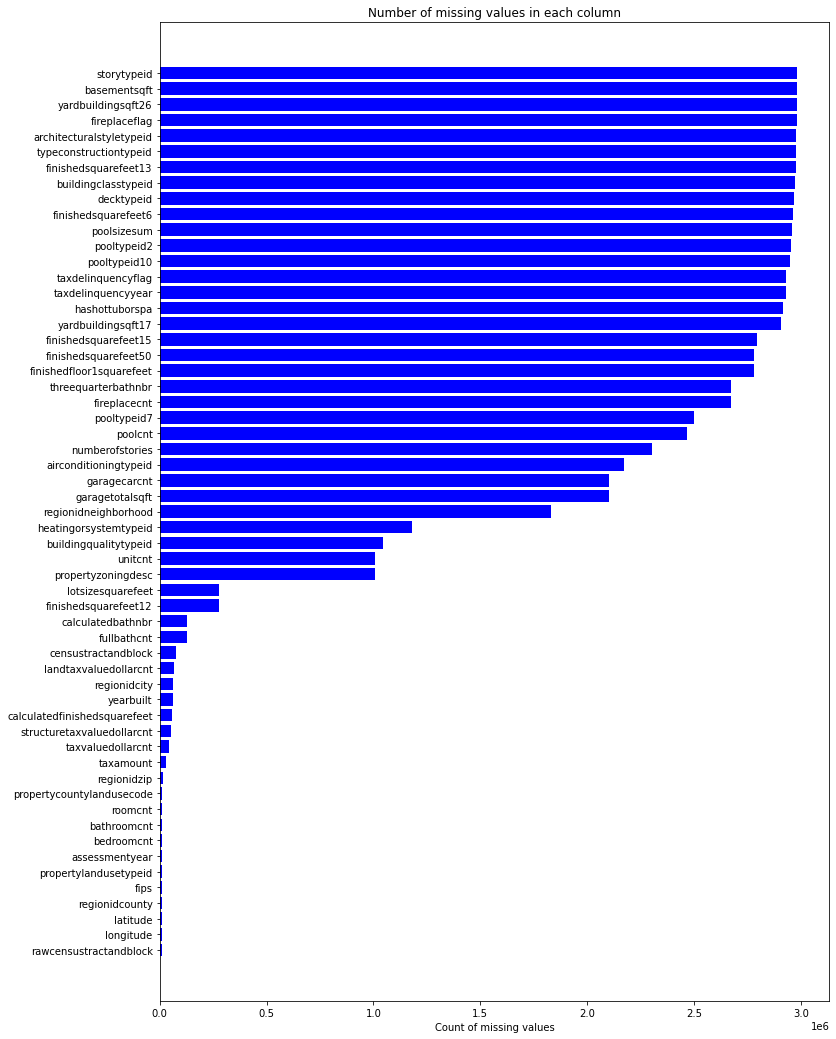

In [10]:
missing_df = prop_df.isnull().sum(axis=0).reset_index()
missing_df.columns = ['column_name', 'missing_count']
missing_df = missing_df.loc[missing_df['missing_count']>0]
missing_df = missing_df.sort_values(by='missing_count')

ind = np.arange(missing_df.shape[0])
width = 0.9
fig, ax = plt.subplots(figsize=(12,18))
rects = ax.barh(ind, missing_df.missing_count.values, color='blue')
ax.set_yticks(ind)
ax.set_yticklabels(missing_df.column_name.values, rotation='horizontal')
ax.set_xlabel("Count of missing values")
ax.set_title("Number of missing values in each column")
plt.show()

먼저 위도와 경도 변수를 살펴보겠습니다.


C:\Users\HOME\anaconda3\lib\site-packages\seaborn\axisgrid.py:2182: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


<Figure size 864x864 with 0 Axes>

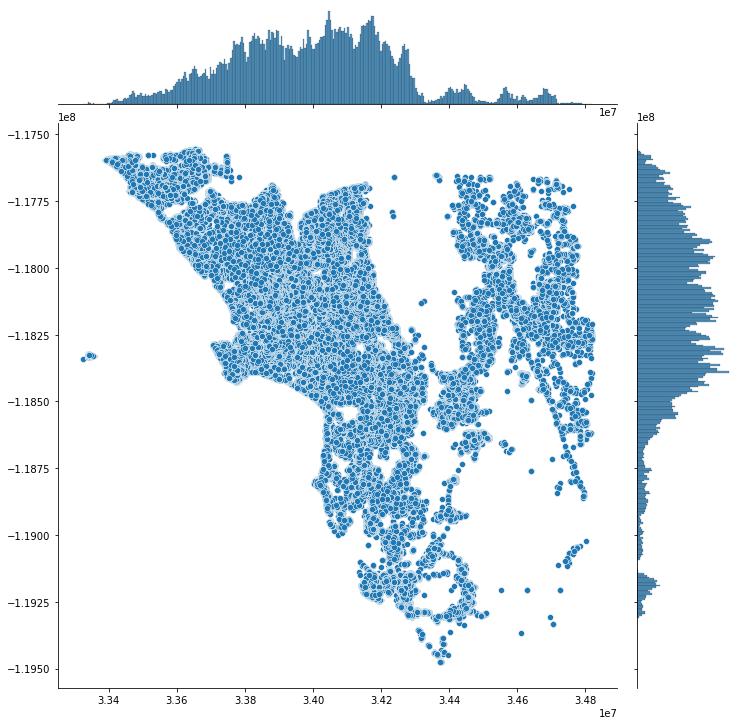

In [11]:
plt.figure(figsize=(12,12))
sns.jointplot(x=prop_df.latitude.values, y=prop_df.longitude.values, size=10)
plt.ylabel('Longitude', fontsize=12)
plt.xlabel('Latitude', fontsize=12)
plt.show()

데이터 페이지에서 *2016년 3개 카운티(로스앤젤레스, 오렌지 및 벤츄라, 캘리포니아)의 부동산 자산 전체 목록이 제공됩니다.*

train에는 약 (90,275, 3)개의 행이 있지만 properties_2016.csv에는 약 (2985217, 58)개의 행이 있습니다. 두 파일을 병합한 다음 분석을 수행해 보겠습니다.


In [12]:
train_df = pd.merge(train_df, prop_df, on='parcelid', how='left')
train_df.head() # (90275, 61)

,parcelid,logerror,transactiondate,transaction_month,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,finishedfloor1squarefeet,calculatedfinishedsquarefeet,finishedsquarefeet12,finishedsquarefeet13,finishedsquarefeet15,finishedsquarefeet50,finishedsquarefeet6,fips,fireplacecnt,fullbathcnt,garagecarcnt,garagetotalsqft,hashottuborspa,heatingorsystemtypeid,latitude,longitude,lotsizesquarefeet,poolcnt,poolsizesum,pooltypeid10,pooltypeid2,pooltypeid7,propertycountylandusecode,propertylandusetypeid,propertyzoningdesc,rawcensustractandblock,regionidcity,regionidcounty,regionidneighborhood,regionidzip,roomcnt,storytypeid,threequarterbathnbr,typeconstructiontypeid,unitcnt,yardbuildingsqft17,yardbuildingsqft26,yearbuilt,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock
0,11016594,0.0276,2016-01-01,1,1.0,NaN,NaN,2.0,3.0,NaN,4.0,2.0,NaN,NaN,1684.0,1684.0,NaN,NaN,NaN,NaN,6037.0,NaN,2.0,NaN,NaN,NaN,2.0,34280990.0,-118488536.0,7528.0,NaN,NaN,NaN,NaN,NaN,0100,261.0,LARS,6.037107e+07,12447.0,3101.0,31817.0,96370.0,0.0,NaN,NaN,NaN,1.0,NaN,NaN,1959.0,NaN,NaN,122754.0,360170.0,2015.0,237416.0,6735.88,NaN,NaN,6.037107e+13
1,14366692,-0.1684,2016-01-01,1,NaN,NaN,NaN,3.5,4.0,NaN,NaN,3.5,NaN,NaN,2263.0,2263.0,NaN,NaN,NaN,NaN,6059.0,NaN,3.0,2.0,468.0,NaN,NaN,33668120.0,-117677556.0,3643.0,NaN,NaN,NaN,NaN,NaN,1,261.0,NaN,6.059052e+07,32380.0,1286.0,NaN,96962.0,0.0,NaN,1.0,NaN,NaN,NaN,NaN,2014.0,NaN,NaN,346458.0,585529.0,2015.0,239071.0,10153.02,NaN,NaN,NaN
2,12098116,-0.0040,2016-01-01,1,1.0,NaN,NaN,3.0,2.0,NaN,4.0,3.0,NaN,NaN,2217.0,2217.0,NaN,NaN,NaN,NaN,6037.0,NaN,3.0,NaN,NaN,NaN,2.0,34136312.0,-118175032.0,11423.0,NaN,NaN,NaN,NaN,NaN,0100,261.0,PSR6,6.037464e+07,47019.0,3101.0,275411.0,96293.0,0.0,NaN,NaN,NaN,1.0,NaN,NaN,1940.0,NaN,NaN,61994.0,119906.0,2015.0,57912.0,11484.48,NaN,NaN,6.037464e+13
3,12643413,0.0218,2016-01-02,1,1.0,NaN,NaN,2.0,2.0,NaN,4.0,2.0,NaN,NaN,839.0,839.0,NaN,NaN,NaN,NaN,6037.0,NaN,2.0,NaN,NaN,NaN,2.0,33755800.0,-118309000.0,70859.0,NaN,NaN,NaN,NaN,NaN,010C,266.0,LAR3,6.037296e+07,12447.0,3101.0,54300.0,96222.0,0.0,NaN,NaN,NaN,1.0,NaN,NaN,1987.0,NaN,NaN,171518.0,244880.0,2015.0,73362.0,3048.74,NaN,NaN,6.037296e+13
4,14432541,-0.0050,2016-01-02,1,NaN,NaN,NaN,2.5,4.0,NaN,NaN,2.5,NaN,NaN,2283.0,2283.0,NaN,NaN,NaN,NaN,6059.0,NaN,2.0,2.0,598.0,NaN,NaN,33485643.0,-117700234.0,6000.0,1.0,NaN,NaN,NaN,1.0,122,261.0,NaN,6.059042e+07,17686.0,1286.0,NaN,96961.0,8.0,NaN,1.0,NaN,NaN,NaN,NaN,1981.0,2.0,NaN,169574.0,434551.0,2015.0,264977.0,5488.96,NaN,NaN,6.059042e+13


In [13]:
train_df.shape

(90275, 61)

이제 다양한 유형의 변수에 대한 dtypes를 확인해 보겠습니다.


In [14]:
pd.options.display.max_rows = 65

dtype_df = train_df.dtypes.reset_index()
dtype_df.columns = ["Count", "Column Type"]
dtype_df

,Count,Column Type
0,parcelid,int64
1,logerror,float64
2,transactiondate,datetime64[ns]
3,transaction_month,int64
4,airconditioningtypeid,float64
5,architecturalstyletypeid,float64
6,basementsqft,float64
7,bathroomcnt,float64
8,bedroomcnt,float64
9,buildingclasstypeid,float64


거의 모든 것이 object/float 변수입니다. 카운트를 구합시다.

In [15]:
dtype_df.groupby("Column Type").aggregate('count').reset_index()

,Column Type,Count
0,int64,2
1,float64,53
2,datetime64[ns],1
3,object,5


이제 이 새로 병합된 데이터 세트에서 Null의 수를 확인하겠습니다.


In [16]:
missing_df = train_df.isnull().sum(axis=0).reset_index()
missing_df.columns = ['column_name', 'missing_count']
missing_df['missing_ratio'] = missing_df['missing_count'] / train_df.shape[0]
missing_df.loc[missing_df['missing_ratio']>0.999]

,column_name,missing_count,missing_ratio
6,basementsqft,90232,0.999524
9,buildingclasstypeid,90259,0.999823
16,finishedsquarefeet13,90242,0.999634
44,storytypeid,90232,0.999524


4개의 열에 99.9%의 확률로 결측값이 있습니다.!


**일변량 분석:**

변수가 너무 많기 때문에 먼저 'float' 변수만 취한 다음 대상 변수와의 상관 관계를 확인하여 관련성을 살펴보겠습니다.

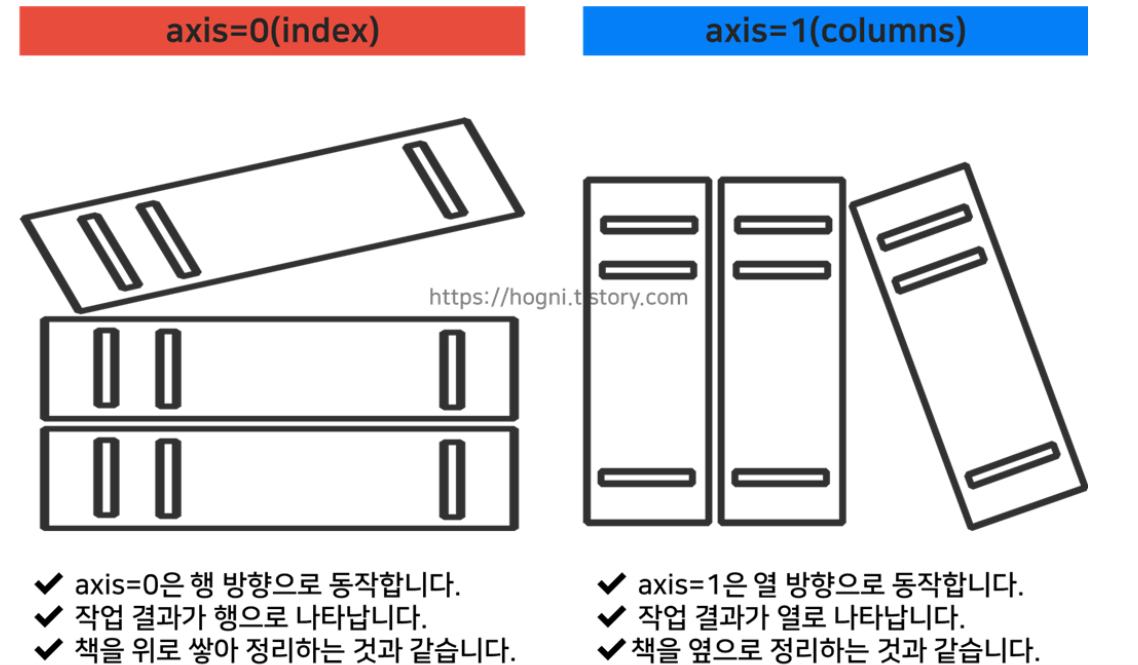

C:\Users\HOME\AppData\Local\Temp/ipykernel_12316/816595417.py:2: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  mean_values = train_df.mean(axis=0)
C:\Users\HOME\AppData\Local\Temp/ipykernel_12316/816595417.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  mean_values = train_df.mean(axis=0)
C:\Users\HOME\anaconda3\lib\site-packages\numpy\lib\function_base.py:2642: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\HOME\anaconda3\lib\site-packages\numpy\lib\function_base.py:2643: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


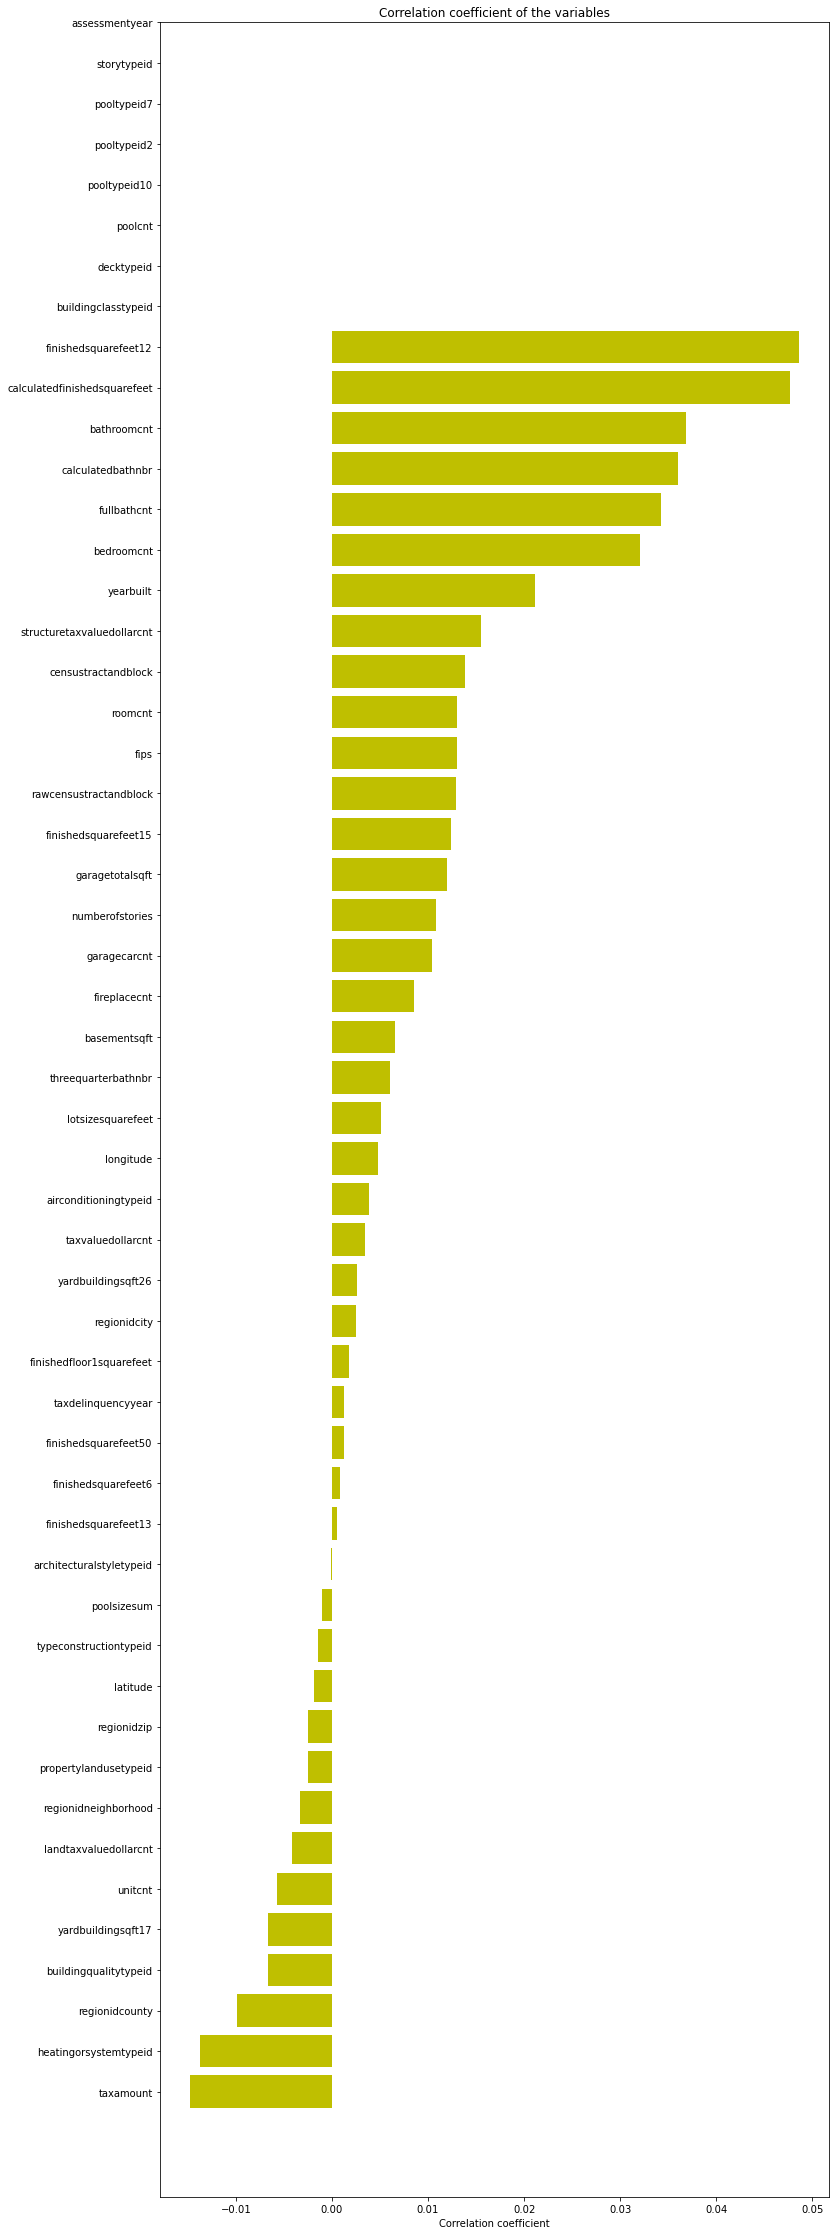

In [17]:
# 상관 계수를 계산하기 위해 누락된 값을 평균 값으로 대치합시다. #
mean_values = train_df.mean(axis=0)
train_df_new = train_df.fillna(mean_values)
train_df.fillna(mean_values, inplace=True)


# 이제 이러한 각 변수의 상관 계수를 살펴보겠습니다. #
# 이름에 logerror가 들어간 것 & dtype='float64'는 제외
x_cols = [col for col in train_df_new.columns if col not in ['logerror'] if train_df_new[col].dtype=='float64']

labels = []
values = []
for col in x_cols:
    labels.append(col)
    values.append(np.corrcoef(train_df_new[col].values, train_df_new['logerror'].values)[0,1]) # np.corrcoef(x,y)[0,1]
    
corr_df = pd.DataFrame({'col_labels':labels, 'corr_values':values})
corr_df = corr_df.sort_values(by='corr_values')
    
ind = np.arange(len(labels))
width = 0.9
fig, ax = plt.subplots(figsize=(12,40))
rects = ax.barh(ind, np.array(corr_df['corr_values'].values), color='y')
ax.set_yticks(ind)
ax.set_yticklabels(corr_df.col_labels.values, rotation='horizontal')
ax.set_xlabel("Correlation coefficient")
ax.set_title("Correlation coefficient of the variables")
#autolabel(rects)
plt.show()

주어진 변수와 목표 변수의 상관관계는 전반적으로 낮습니다.

이 그래프의 상단에는 상관값이 없는 변수가 있습니다. 고유한 값이 하나만 있으므로 상관 값이 없는 것 같습니다. 같은 것을 확인합시다.

In [18]:
corr_zero_cols = ['assessmentyear', 'storytypeid', 'pooltypeid2', 'pooltypeid7', 'pooltypeid10', 'poolcnt', 'decktypeid', 'buildingclasstypeid']
for col in corr_zero_cols:
    print(col, len(train_df_new[col].unique()))

assessmentyear 1
storytypeid 1
pooltypeid2 1
pooltypeid7 1
pooltypeid10 1
poolcnt 1
decktypeid 1
buildingclasstypeid 1


상관 값이 높은 변수를 가져와서 분석해 보겠습니다.


In [19]:
corr_df_sel = corr_df.loc[(corr_df['corr_values']>0.02) | (corr_df['corr_values'] < -0.01)]
corr_df_sel

,col_labels,corr_values
49,taxamount,-0.014768
21,heatingorsystemtypeid,-0.013732
43,yearbuilt,0.021171
4,bedroomcnt,0.032035
18,fullbathcnt,0.034267
7,calculatedbathnbr,0.036019
3,bathroomcnt,0.036862
10,calculatedfinishedsquarefeet,0.047659
11,finishedsquarefeet12,0.048611


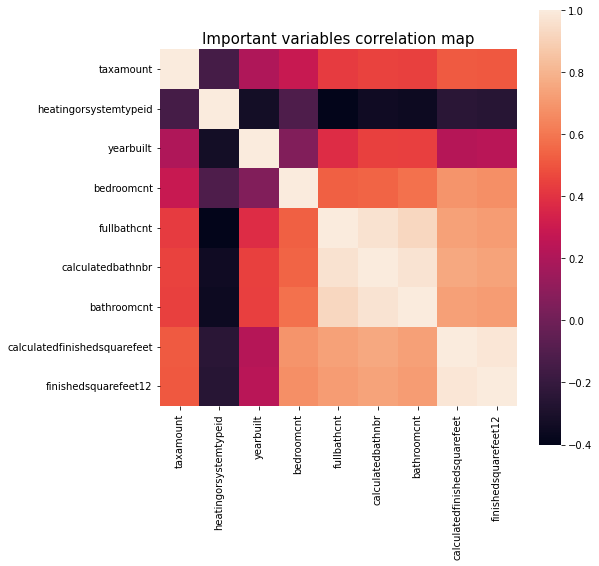

In [20]:
cols_to_use = corr_df_sel['col_labels'].tolist()

temp_df = train_df[cols_to_use]
corrmat = temp_df.corr(method='spearman')
f, ax = plt.subplots(figsize=(8, 8))

# Draw the heatmap using seaborn
sns.heatmap(corrmat, vmax=1., square=True)
plt.title("Important variables correlation map", fontsize=15)
plt.show()

중요한 변수 자체는 매우 높은 상관관계를 가지고 있습니다.! 이제 각각에 대해 살펴보겠습니다.
**Finished SquareFeet 12:**

완성된 제곱피트(12)가 로그 오류에 따라 어떻게 달라지는지 봅시다.


C:\Users\HOME\anaconda3\lib\site-packages\seaborn\axisgrid.py:2182: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


<Figure size 864x864 with 0 Axes>

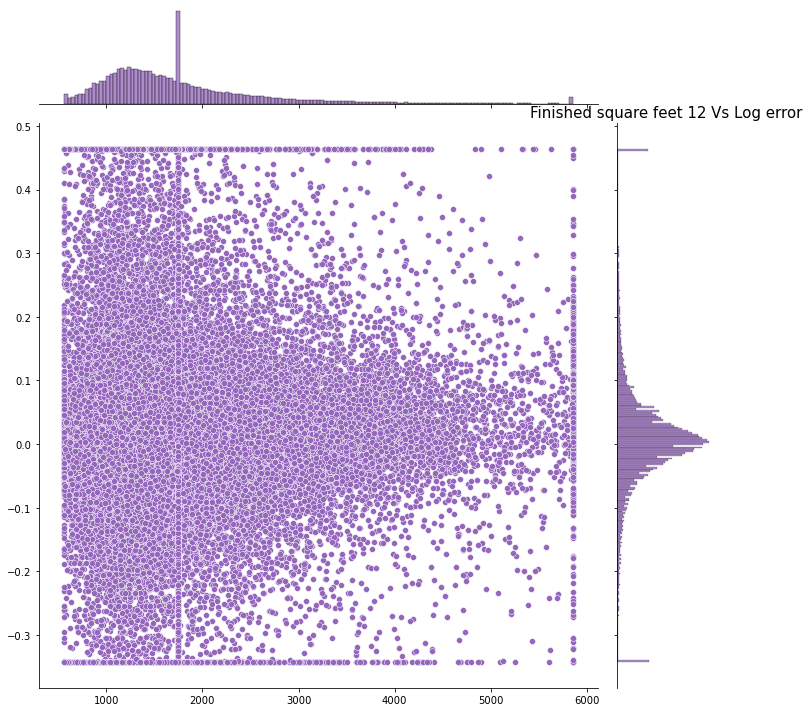

In [21]:
# 첫번째로 상관관계가 높은 변수
col = "finishedsquarefeet12"
ulimit = np.percentile(train_df[col].values, 99.5)
llimit = np.percentile(train_df[col].values, 0.5)
train_df[col].loc[train_df[col]>ulimit] = ulimit
train_df[col].loc[train_df[col]<llimit] = llimit

plt.figure(figsize=(12,12))
sns.jointplot(x=train_df['finishedsquarefeet12'].values, y=train_df['logerror'].values, size=10, color=color[4])
plt.ylabel('Log Error', fontsize=12)
plt.xlabel('Finished Square Feet 12', fontsize=12)
plt.title("Finished square feet 12 Vs Log error", fontsize=15)
plt.show()

완성된 평방 피트 12 변수가 증가함에 따라 logerror의 범위가 좁아지는 것 같습니다. 아마도 더 큰 집은 쉽게 예측할 수 있습니까?

**Calculated finished square feet:**

C:\Users\HOME\anaconda3\lib\site-packages\seaborn\axisgrid.py:2182: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


<Figure size 864x864 with 0 Axes>

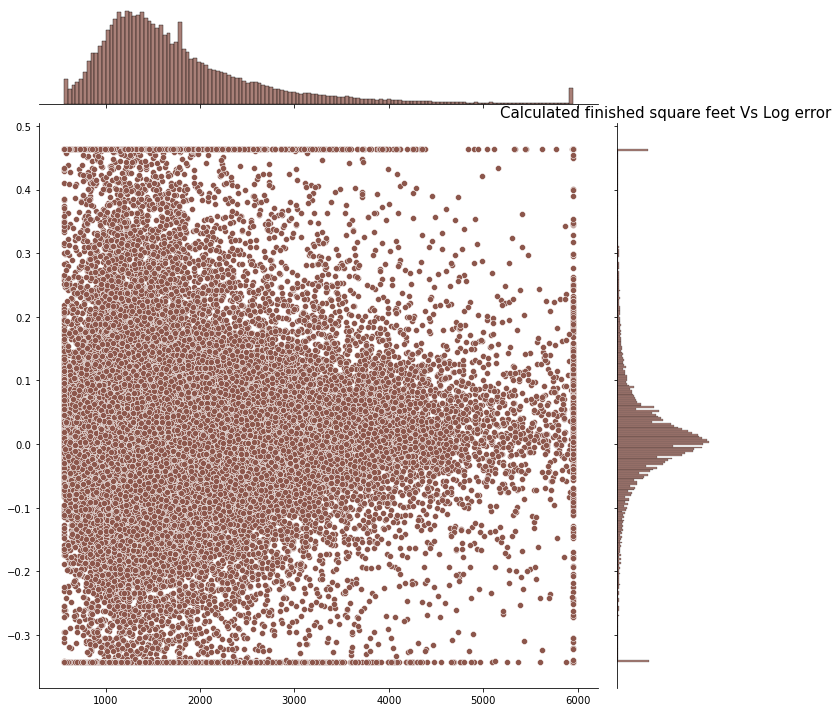

In [22]:
# 두번째로 상관관계가 높은 변수
col = "calculatedfinishedsquarefeet"
ulimit = np.percentile(train_df[col].values, 99.5)
llimit = np.percentile(train_df[col].values, 0.5)
train_df[col].loc[train_df[col]>ulimit] = ulimit
train_df[col].loc[train_df[col]<llimit] = llimit

plt.figure(figsize=(12,12))
sns.jointplot(x=train_df.calculatedfinishedsquarefeet.values, y=train_df.logerror.values, size=10, color=color[5])
plt.ylabel('Log Error', fontsize=12)
plt.xlabel('Calculated finished square feet', fontsize=12)
plt.title("Calculated finished square feet Vs Log error", fontsize=15)
plt.show()

여기에서도 분포는 이전과 매우 유사합니다. 두 변수 간의 상관관계도 높은 것은 당연합니다.

**Bathroom Count:**

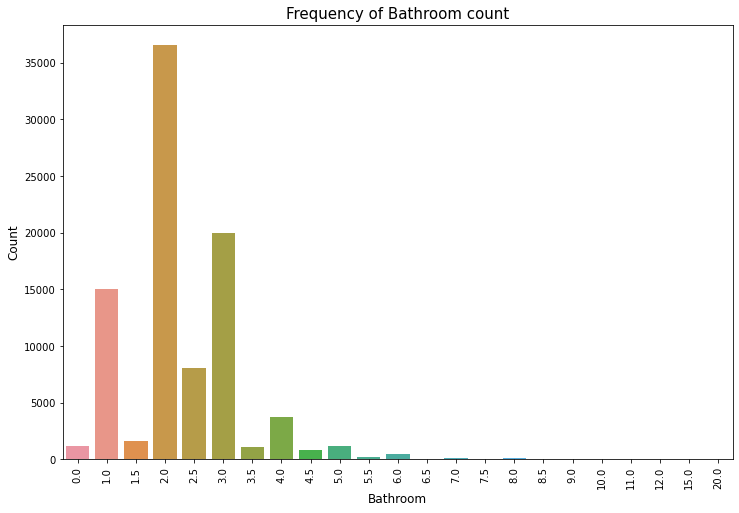

In [23]:
plt.figure(figsize=(12,8))
sns.countplot(x="bathroomcnt", data=train_df)
plt.ylabel('Count', fontsize=12)
plt.xlabel('Bathroom', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Frequency of Bathroom count", fontsize=15)
plt.show()

욕실 수에는 흥미로운 2.279 값이 있습니다.

편집 : MihwaHan이 의견에서 지적했듯이 이것은 평균 값입니다 :)

이제 이를 기반으로 로그 오류가 어떻게 변하는지 확인해보자.

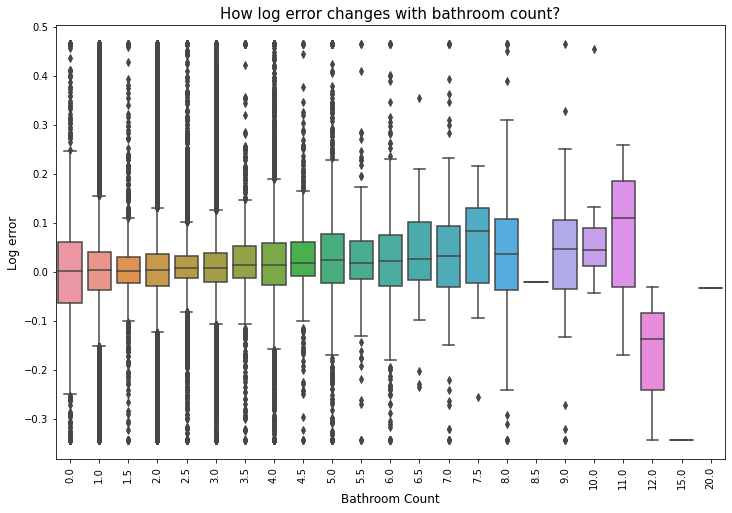

In [24]:
plt.figure(figsize=(12,8))
sns.boxplot(x="bathroomcnt", y="logerror", data=train_df)
plt.ylabel('Log error', fontsize=12)
plt.xlabel('Bathroom Count', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("How log error changes with bathroom count?", fontsize=15)
plt.show()

**Bedroom count:**

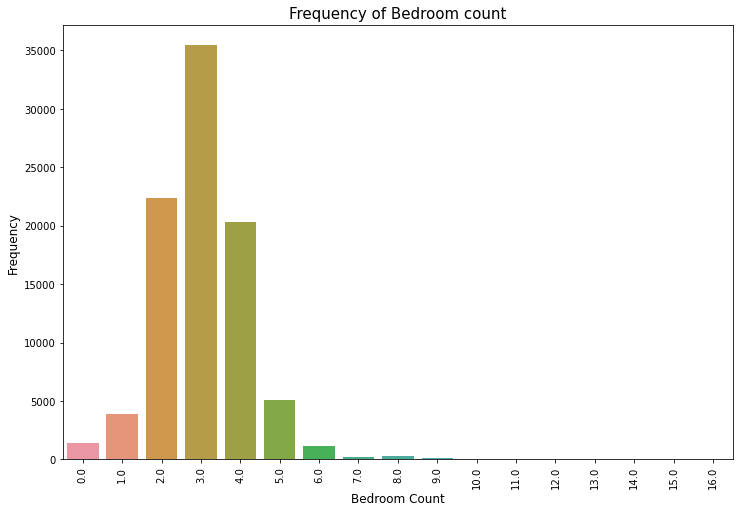

In [25]:
plt.figure(figsize=(12,8))
sns.countplot(x="bedroomcnt", data=train_df)
plt.ylabel('Frequency', fontsize=12)
plt.xlabel('Bedroom Count', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Frequency of Bedroom count", fontsize=15)
plt.show()

3.03 is the mean value with which we replaced the Null values.

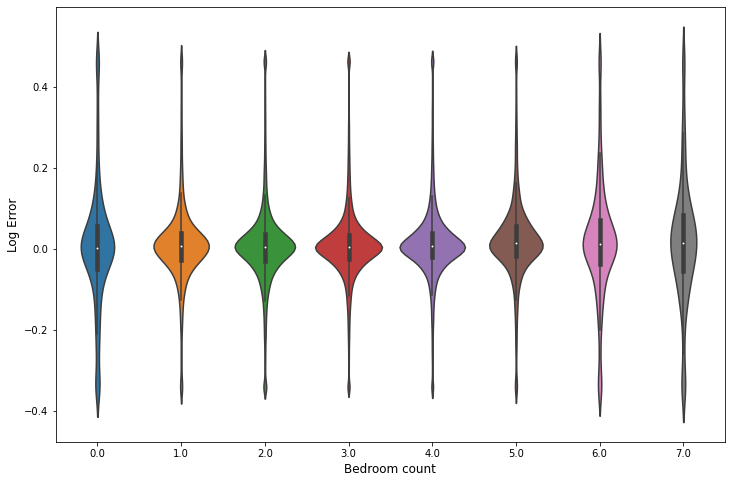

In [26]:
train_df['bedroomcnt'].loc[train_df['bedroomcnt']>7] = 7
plt.figure(figsize=(12,8))
sns.violinplot(x='bedroomcnt', y='logerror', data=train_df)
plt.xlabel('Bedroom count', fontsize=12)
plt.ylabel('Log Error', fontsize=12)
plt.show()

C:\Users\HOME\anaconda3\lib\site-packages\seaborn\axisgrid.py:2182: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


<Figure size 864x864 with 0 Axes>

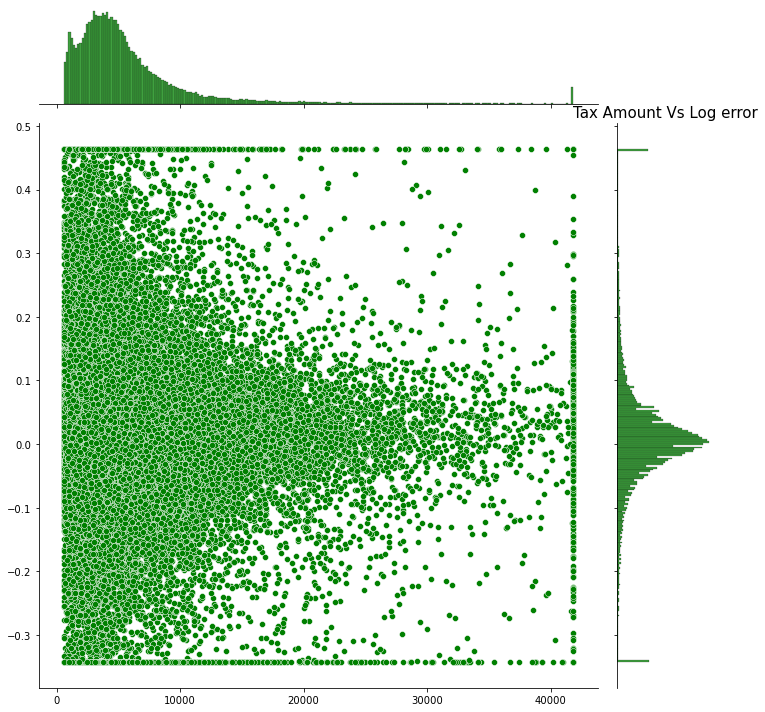

In [27]:
col = "taxamount"
ulimit = np.percentile(train_df[col].values, 99.5)
llimit = np.percentile(train_df[col].values, 0.5)
train_df[col].loc[train_df[col]>ulimit] = ulimit
train_df[col].loc[train_df[col]<llimit] = llimit

plt.figure(figsize=(12,12))
sns.jointplot(x=train_df['taxamount'].values, y=train_df['logerror'].values, size=10, color='g')
plt.ylabel('Log Error', fontsize=12)
plt.xlabel('Tax Amount', fontsize=12)
plt.title("Tax Amount Vs Log error", fontsize=15)
plt.show()

**YearBuilt:**

yearbuilt 변수에 따라 오류가 어떻게 달라지는지 살펴보겠습니다.


C:\Users\HOME\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


AttributeError: 'DataFrame' object has no attribute 'sort'

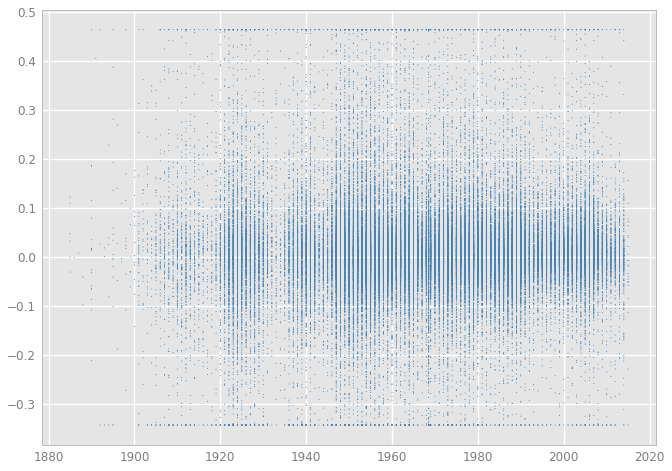

In [28]:
from ggplot import *
ggplot(aes(x='yearbuilt', y='logerror'), data=train_df) + \
    geom_point(color='steelblue', size=1) + \
    stat_smooth()

건설 연도와 관련하여 약간의 증가 추세가 보입니다.

이제 위도와 경도에 따라 logerror가 어떻게 변하는지 봅시다.

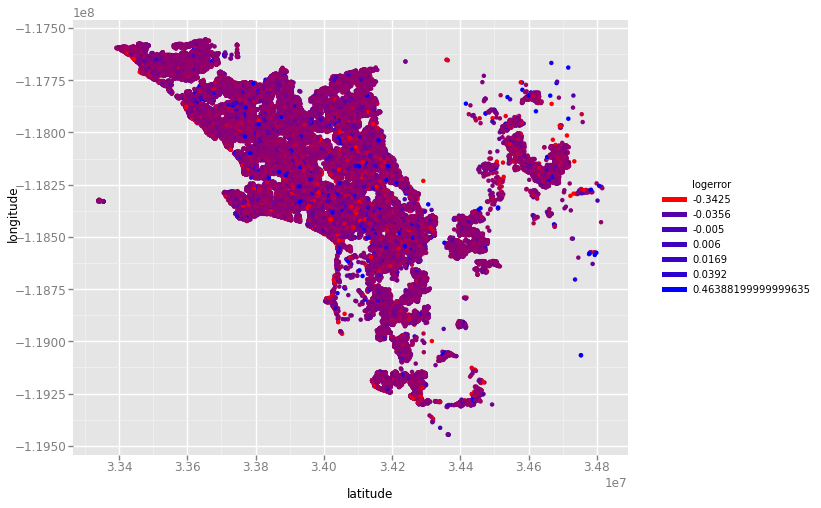

<ggplot: (152882536144)>

In [29]:
ggplot(aes(x='latitude', y='longitude', color='logerror'), data=train_df) + \
    geom_point() + \
    scale_color_gradient(low = 'red', high = 'blue')

육안으로 최소한 위도 또는 경도와 관련하여 보이는 주머니가 없습니다.

가장 높은 양의 상관 관계와 가장 높은 음의 상관 관계를 가진 변수를 사용하여 눈에 보이는 패턴을 볼 수 있는지 알아보겠습니다.

C:\Users\HOME\anaconda3\lib\site-packages\ggplot\scales\scale_color_gradient.py:59: UserWarning: Trying to register the cmap 'gradient2n' which already exists.
  plt.cm.register_cmap(cmap=gradient2n)


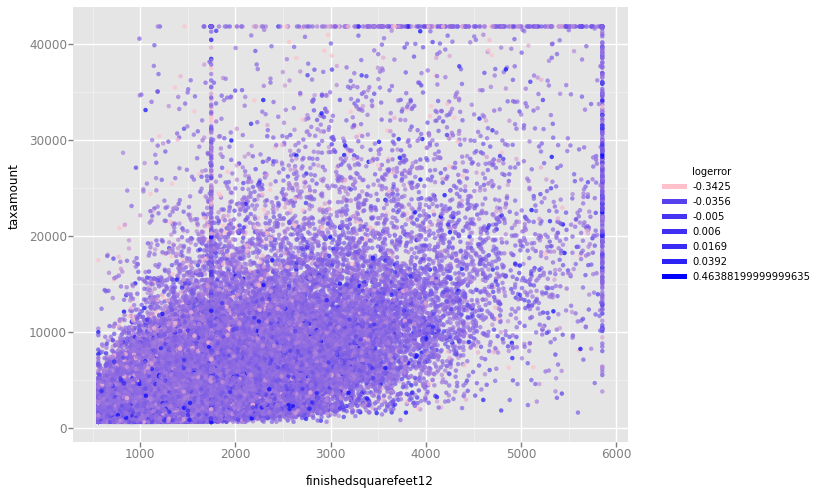

<ggplot: (152922565599)>

In [30]:
ggplot(aes(x='finishedsquarefeet12', y='taxamount', color='logerror'), data=train_df) + \
    geom_point(alpha=0.7) + \
    scale_color_gradient(low = 'pink', high = 'blue')

여기에도 눈에 보이는 패턴이 없습니다. 그래서 예측하기 힘든 경쟁이 될 것 같아요.

재미를 위해 기계가 우리를 위해 임의의 패턴을 형성하게 할 것입니다 :D

Put a bird on it!


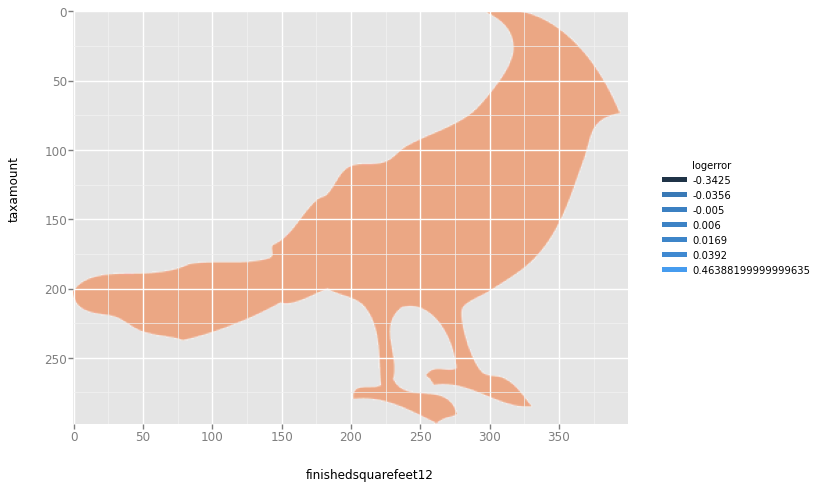

<ggplot: (152925735340)>

In [31]:
ggplot(aes(x='finishedsquarefeet12', y='taxamount', color='logerror'), data=train_df) + \
    geom_now_its_art()

만세.! 마침내 우리는 데이터에서 멋진 패턴을 얻었습니다 :P

우리는 일변량 분석에서 중요한 변수를 이해했습니다. 그러나 이것은 독립형 기반이며 선형성 가정도 있습니다. 이제 Extra Trees 모델을 구축하여 중요한 변수를 얻기 위한 비선형 모델을 구축해 보겠습니다.

In [32]:
train_df

,parcelid,logerror,transactiondate,transaction_month,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,finishedfloor1squarefeet,calculatedfinishedsquarefeet,finishedsquarefeet12,finishedsquarefeet13,finishedsquarefeet15,finishedsquarefeet50,finishedsquarefeet6,fips,fireplacecnt,fullbathcnt,garagecarcnt,garagetotalsqft,hashottuborspa,heatingorsystemtypeid,latitude,longitude,lotsizesquarefeet,poolcnt,poolsizesum,pooltypeid10,pooltypeid2,pooltypeid7,propertycountylandusecode,propertylandusetypeid,propertyzoningdesc,rawcensustractandblock,regionidcity,regionidcounty,regionidneighborhood,regionidzip,roomcnt,storytypeid,threequarterbathnbr,typeconstructiontypeid,unitcnt,yardbuildingsqft17,yardbuildingsqft26,yearbuilt,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock
0,11016594,0.0276,2016-01-01,1,1.000000,7.229885,713.581395,2.0,3.0,4.0,4.000000,2.0,66.0,1347.974037,1684.0,1684.000000,1404.545455,2380.090067,1355.546674,2302.546318,6037.0,1.187884,2.0,1.812005,345.521228,1.0,2.000000,34280990.0,-118488536.0,7528.0,1.0,519.827657,1.0,1.0,1.0,0100,261.0,LARS,6.037107e+07,12447.000000,3101.0,31817.000000,96370.0,0.0,7.0,1.008743,6.010033,1.000000,310.142101,311.694737,1959.0,1.440739,1.0,122754.0,360170.0,2015.0,237416.0,6735.88,NaN,13.402692,6.037107e+13
1,14366692,-0.1684,2016-01-01,1,1.816372,7.229885,713.581395,3.5,4.0,4.0,5.565407,3.5,66.0,1347.974037,2263.0,2263.000000,1404.545455,2380.090067,1355.546674,2302.546318,6059.0,1.187884,3.0,2.000000,468.000000,1.0,3.926979,33668120.0,-117677556.0,3643.0,1.0,519.827657,1.0,1.0,1.0,1,261.0,NaN,6.059052e+07,32380.000000,1286.0,190646.540237,96962.0,0.0,7.0,1.000000,6.010033,1.110414,310.142101,311.694737,2014.0,1.440739,1.0,346458.0,585529.0,2015.0,239071.0,10153.02,NaN,13.402692,6.049151e+13
2,12098116,-0.0040,2016-01-01,1,1.000000,7.229885,713.581395,3.0,2.0,4.0,4.000000,3.0,66.0,1347.974037,2217.0,2217.000000,1404.545455,2380.090067,1355.546674,2302.546318,6037.0,1.187884,3.0,1.812005,345.521228,1.0,2.000000,34136312.0,-118175032.0,11423.0,1.0,519.827657,1.0,1.0,1.0,0100,261.0,PSR6,6.037464e+07,47019.000000,3101.0,275411.000000,96293.0,0.0,7.0,1.008743,6.010033,1.000000,310.142101,311.694737,1940.0,1.440739,1.0,61994.0,119906.0,2015.0,57912.0,11484.48,NaN,13.402692,6.037464e+13
3,12643413,0.0218,2016-01-02,1,1.000000,7.229885,713.581395,2.0,2.0,4.0,4.000000,2.0,66.0,1347.974037,839.0,839.000000,1404.545455,2380.090067,1355.546674,2302.546318,6037.0,1.187884,2.0,1.812005,345.521228,1.0,2.000000,33755800.0,-118309000.0,70859.0,1.0,519.827657,1.0,1.0,1.0,010C,266.0,LAR3,6.037296e+07,12447.000000,3101.0,54300.000000,96222.0,0.0,7.0,1.008743,6.010033,1.000000,310.142101,311.694737,1987.0,1.440739,1.0,171518.0,244880.0,2015.0,73362.0,3048.74,NaN,13.402692,6.037296e+13
4,14432541,-0.0050,2016-01-02,1,1.816372,7.229885,713.581395,2.5,4.0,4.0,5.565407,2.5,66.0,1347.974037,2283.0,2283.000000,1404.545455,2380.090067,1355.546674,2302.546318,6059.0,1.187884,2.0,2.000000,598.000000,1.0,3.926979,33485643.0,-117700234.0,6000.0,1.0,519.827657,1.0,1.0,1.0,122,261.0,NaN,6.059042e+07,17686.000000,1286.0,190646.540237,96961.0,8.0,7.0,1.000000,6.010033,1.110414,310.142101,311.694737,1981.0,2.000000,1.0,169574.0,434551.0,2015.0,264977.0,5488.96,NaN,13.402692,6.059042e+13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90270,10774160,-0.0356,2016-12-30,12,1.000000,7.229885,713.581395,1.0,1.0,4.0,4.000000,1.0,66.0,1347.974037,653.0,653.000000,1404.545455,2380.090067,1355.546674,2302.546318,6037.0,1.187884,1.0,1.812005,345.521228,1.0,2.000000,34203000.0,-118562000.0,93676.0,1.0,519.82

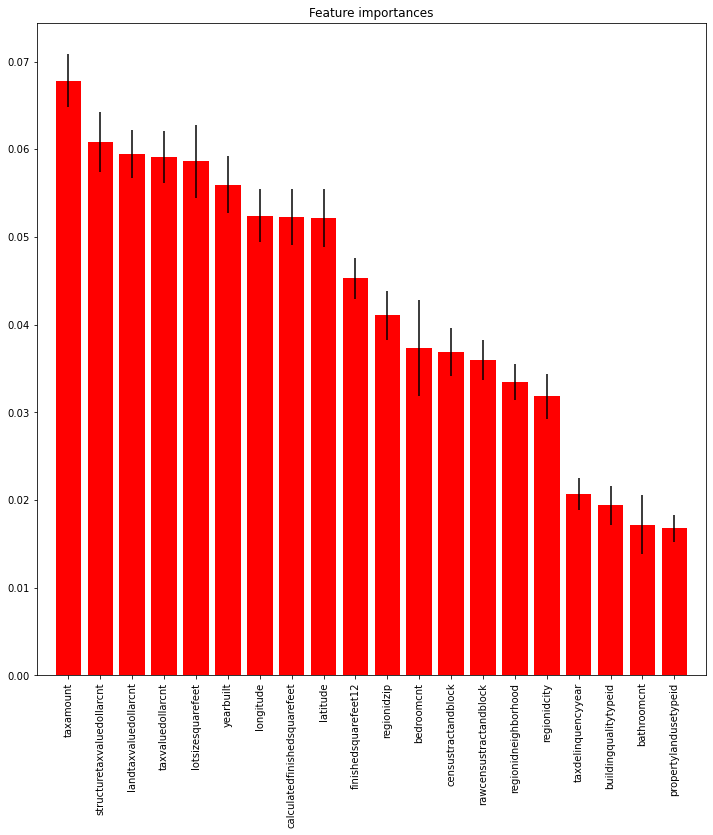

In [33]:
train_y = train_df['logerror'].values
cat_cols = ["hashottuborspa", "propertycountylandusecode", "propertyzoningdesc", "fireplaceflag", "taxdelinquencyflag"]
train_df = train_df.drop(['parcelid', 'logerror', 'transactiondate', 'transaction_month']+cat_cols, axis=1)
feat_names = train_df.columns.values

from sklearn import ensemble
model = ensemble.ExtraTreesRegressor(n_estimators=25, max_depth=30, max_features=0.3, n_jobs=-1, random_state=0)
model.fit(train_df, train_y)

## plot the importances ##
importances = model.feature_importances_
std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)
indices = np.argsort(importances)[::-1][:20]

plt.figure(figsize=(12,12))
plt.title("Feature importances")
plt.bar(range(len(indices)), importances[indices], color="r", yerr=std[indices], align="center")
plt.xticks(range(len(indices)), feat_names[indices], rotation='vertical')
plt.xlim([-1, len(indices)])
plt.show()

"세액"이 가장 중요한 변수로 "구조 세금 가치 달러 수"와 "토지 세금 가치 달러 수"가 뒤따르는 것 같습니다.


[15:55:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[15:55:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




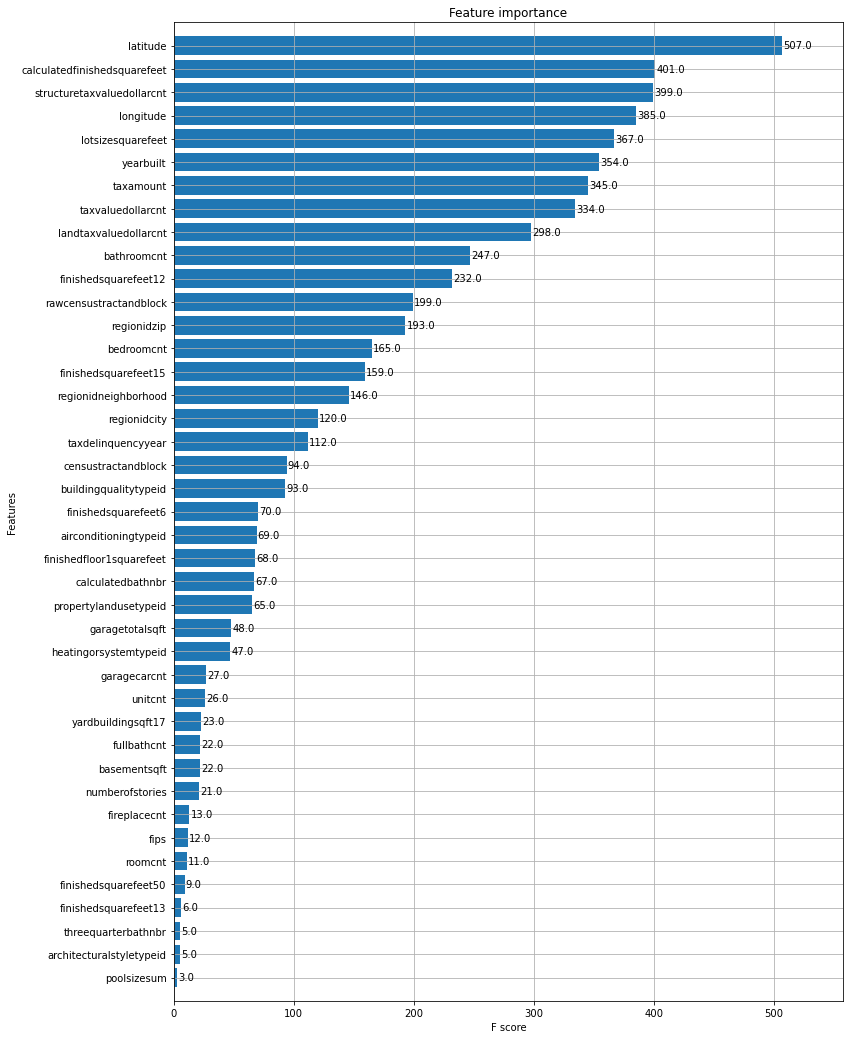

In [34]:
import xgboost as xgb
xgb_params = {
    'eta': 0.05,
    'max_depth': 8,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'objective': 'reg:linear',
    'silent': 1,
    'seed' : 0
}
dtrain = xgb.DMatrix(train_df, train_y, feature_names=train_df.columns.values)
model = xgb.train(dict(xgb_params, silent=0), dtrain, num_boost_round=50)

# plot the important features #
fig, ax = plt.subplots(figsize=(12,18))
xgb.plot_importance(model, max_num_features=50, height=0.8, ax=ax)
plt.show()

xgboost를 사용하면 중요한 변수는 '구조화된 세금 가치 달러 수' 다음에 '위도' 및 '계산된 완성 평방 피트'입니다.


**More to come. Stay tuned.!**

**Please upvote if you find it useful :)**